In [ ]:
!pip install -q nltk

In [16]:
from google.colab import files
from tqdm import tqdm
import gcsfs
import os
import pandas as pd
import dask.dataframe as dd
import gc
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from dask.diagnostics import ProgressBar
import numpy as np
import calendar
import itertools
import random
from datetime import datetime
import json
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [24]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
# adding a progress bar for every code run using dask
ProgressBar().register()

In [3]:
# loading the data from parquet files
df_2019 = dd.read_parquet('/content/feb_apr_2019_export/*.parquet')
df_2020 = dd.read_parquet('/content/feb_apr_2020_export/*.parquet')

In [3]:
# taking only required columns to reduce computational load
df_2019 = df_2019[['created_at', 'type', 'repo', 'actor', 'payload']]
df_2020 = df_2020[['created_at', 'type', 'repo', 'actor', 'payload']]

In [4]:
# selecting relevant event types
relevant_types = ['PushEvent', 'IssueCommentEvent', 'PullRequestReviewCommentEvent']

For sentiment analysis, I focused on PushEvent and IssueCommentEvent because they are rich in developer written text such as commit messages and issue discussions. Other types may not have meaningful text content.

In [5]:
# selecting relevant event types only to the df's
df_2019 = df_2019[df_2019['type'].isin(relevant_types)]
df_2020 = df_2020[df_2020['type'].isin(relevant_types)]

In [6]:
# checking the type of format for payload column before parsing
sample_payload = df_2019.head(1)['payload'].values[0]

print(type(sample_payload))
print(sample_payload[:300])

<class 'str'>
{"action":"created","comment":{"url":"https://api.github.com/repos/1iveowl/Plugin.SegmentedControl/pulls/comments/257808229","pull_request_review_id":204930035,"id":257808229,"node_id":"MDI0OlB1bGxSZXF1ZXN0UmV2aWV3Q29tbWVudDI1NzgwODIyOQ==","diff_hunk":"@@ -89,7 +89,16 @@ public Color DisabledColor\n


The payload column is still in json formatted string format.

In [2]:
gc.collect()

0

In [8]:
# changing the created_at column format to date time format
df_2019['created_at'] = dd.to_datetime(df_2019['created_at'])
df_2020['created_at'] = dd.to_datetime(df_2020['created_at'])

In [9]:
# creating a new week column with the start date of the each week for weekly analysis
df_2019['week'] = df_2019['created_at'].dt.to_period('W').dt.start_time
df_2020['week'] = df_2020['created_at'].dt.to_period('W').dt.start_time

In [10]:
# function to extract the text from the payload column
def extract_text_save(df, save_dir, label = None):
  # creating a dir to save the files
  os.makedirs(save_dir, exist_ok=True)

  # getting a sorted list of unique weeks
  unique_weeks = df['week'].drop_duplicates().compute().sort_values().tolist()

  # looping through each week to extract text from payload column
  for week in tqdm(unique_weeks, desc = "Extracting text"):
    df_week = df[df['week'] == week].compute()

    # helper function to extract the text
    def getting_text(row):
      # parsing using json
      payload = json.loads(row['payload'])

      # extracting relevant text based on event type
      # extracting commit messages for PushEvents
      if row['type'] == 'PushEvent':
        commits = payload.get('commits', [])
        messages = []
        for commit in commits:
          if 'message' in commit:
            messages.append(commit['message'])
        return ' '.join(messages).strip()
      # extracting comment body for IssueCommentEvent
      elif row['type'] == 'IssueCommentEvent':
        return payload.get('comment', {}).get('body', None)
      # extracting comment body for PullRequestReviewCommentEvent
      elif row['type'] == 'PullRequestReviewCommentEvent':
        return payload.get('comment', {}).get('body', None)
      else:
        return None

    # extracting  text for each row
    df_week['text'] = df_week.apply(getting_text, axis=1)
    df_week = df_week.dropna(subset = ['text'])
    # adding a label
    df_week['label'] = label

    # saving the file
    if not df_week.empty:
      filename = f"week_{week.date()}.parquet"
      full_path = os.path.join(save_dir, filename)

      df_week.to_parquet(full_path, index=False)

    del df_week, week, filename, full_path
    gc.collect()

In [14]:
# extracting text from 2019 data and saving it
extract_text_save(df_2019, save_dir = '/content/sa/2019', label = '2019')

[########################################] | 100% Completed | 55.17 s


Extracting text:   0%|          | 0/14 [00:00<?, ?it/s]

[########################################] | 100% Completed | 190.11 s


Extracting text:   7%|▋         | 1/14 [03:38<47:21, 218.61s/it]

[########################################] | 100% Completed | 198.36 s


Extracting text:  14%|█▍        | 2/14 [08:29<52:13, 261.13s/it]

[########################################] | 100% Completed | 195.12 s


Extracting text:  21%|██▏       | 3/14 [13:29<51:05, 278.66s/it]

[########################################] | 100% Completed | 193.54 s


Extracting text:  29%|██▊       | 4/14 [18:22<47:25, 284.58s/it]

[########################################] | 100% Completed | 200.27 s


Extracting text:  36%|███▌      | 5/14 [23:25<43:41, 291.26s/it]

[########################################] | 100% Completed | 207.23 s


Extracting text:  43%|████▎     | 6/14 [28:40<39:52, 299.07s/it]

[########################################] | 100% Completed | 215.04 s


Extracting text:  50%|█████     | 7/14 [33:53<35:25, 303.69s/it]

[########################################] | 100% Completed | 208.09 s


Extracting text:  57%|█████▋    | 8/14 [39:02<30:32, 305.41s/it]

[########################################] | 100% Completed | 222.09 s


Extracting text:  64%|██████▍   | 9/14 [44:28<25:59, 311.93s/it]

[########################################] | 100% Completed | 218.77 s


Extracting text:  71%|███████▏  | 10/14 [49:48<20:57, 314.45s/it]

[########################################] | 100% Completed | 209.75 s


Extracting text:  79%|███████▊  | 11/14 [54:58<15:39, 313.14s/it]

[########################################] | 100% Completed | 201.88 s


Extracting text:  86%|████████▌ | 12/14 [59:52<10:14, 307.26s/it]

[########################################] | 100% Completed | 216.57 s


Extracting text:  93%|█████████▎| 13/14 [1:05:02<05:08, 308.03s/it]

[########################################] | 100% Completed | 207.55 s


Extracting text: 100%|██████████| 14/14 [1:09:04<00:00, 296.04s/it]


In [16]:
# extracting text from 2019 data
extract_text_save(df_2020, save_dir = '/content/sa/2020', label = '2020')

[########################################] | 100% Completed | 99.57 s


Extracting text:   0%|          | 0/14 [00:00<?, ?it/s]

[########################################] | 100% Completed | 410.82 s


Extracting text:   7%|▋         | 1/14 [07:14<1:34:07, 434.41s/it]

[########################################] | 100% Completed | 413.66 s


Extracting text:  14%|█▍        | 2/14 [16:08<1:38:33, 492.82s/it]

[########################################] | 100% Completed | 423.13 s


Extracting text:  21%|██▏       | 3/14 [25:20<1:35:21, 520.14s/it]

[########################################] | 100% Completed | 415.23 s


Extracting text:  29%|██▊       | 4/14 [34:14<1:27:36, 525.63s/it]

[########################################] | 100% Completed | 420.84 s


Extracting text:  36%|███▌      | 5/14 [43:32<1:20:33, 537.04s/it]

[########################################] | 100% Completed | 412.44 s


Extracting text:  43%|████▎     | 6/14 [52:36<1:11:57, 539.71s/it]

[########################################] | 100% Completed | 439.12 s


Extracting text:  50%|█████     | 7/14 [1:02:19<1:04:37, 553.86s/it]

[########################################] | 100% Completed | 430.17 s


Extracting text:  57%|█████▋    | 8/14 [1:11:48<55:50, 558.39s/it]  

[########################################] | 100% Completed | 424.59 s


Extracting text:  64%|██████▍   | 9/14 [1:21:19<46:52, 562.54s/it]

[########################################] | 100% Completed | 414.89 s


Extracting text:  71%|███████▏  | 10/14 [1:31:04<37:57, 569.26s/it]

[########################################] | 100% Completed | 410.67 s


Extracting text:  79%|███████▊  | 11/14 [1:40:28<28:23, 567.69s/it]

[########################################] | 100% Completed | 423.33 s


Extracting text:  86%|████████▌ | 12/14 [1:49:59<18:57, 568.71s/it]

[########################################] | 100% Completed | 408.81 s


Extracting text:  93%|█████████▎| 13/14 [1:59:23<09:27, 567.39s/it]

[########################################] | 100% Completed | 417.77 s


Extracting text: 100%|██████████| 14/14 [2:08:10<00:00, 549.30s/it]


In [2]:
# loading the text data files to a dask df
sa_2019 = dd.read_parquet('/content/sa/2019/*.parquet')
sa_2020 = dd.read_parquet('/content/sa/2020/*.parquet')

In [12]:
# checking the data types
sa_2019.dtypes

,0
created_at,datetime64[us]
type,string[pyarrow]
repo,string[pyarrow]
actor,string[pyarrow]
payload,string[pyarrow]
week,datetime64[ns]
text,string[pyarrow]
label,string[pyarrow]


In [13]:
sa_2020.head()

,created_at,type,repo,actor,payload,week,text,label
0,2020-02-02 19:10:58,PullRequestReviewCommentEvent,HuwCampbell/grenade,erikd,"{""action"":""created"",""comment"":{""url"":""https://...",2020-01-27,Hlint is a great tool for improving your own H...,2020
1,2020-02-02 16:05:38,PullRequestReviewCommentEvent,Ryujinx/Ryujinx,gdkchan,"{""action"":""created"",""comment"":{""url"":""https://...",2020-01-27,One of the parenthesis is not necessary here. ...,2020
2,2020-02-02 15:31:35,PullRequestReviewCommentEvent,auth0/cosmos,dmiller9911,"{""action"":""created"",""comment"":{""url"":""https://...",2020-01-27,Not sure if these changes are good or bad.,2020
3,2020-02-02 12:47:41,PullRequestReviewCommentEvent,flyimg/flyimg,sadok-f,"{""action"":""created"",""comment"":{""url"":""https://...",2020-01-27,extending the `Processor` class will allow you...,2020
4,2020-02-02 12:43:43,PullRequestReviewCommentEvent,kir-dev/pek-next,falusi94,"{""action"":""created"",""comment"":{""url"":""https://...",2020-01-27,"You are right with the issue, but we are using...",2020


In [6]:
gc.collect()

0

In [3]:
# initializing VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

In [5]:
# function to calculate the sentiment each week
def calc_sentiment(df, batch_size = None):
  # empty list to store results
  sentiment_data = []

  # getting sorted list of unique weeks
  unique_weeks = df['week'].drop_duplicates().compute().sort_values().tolist()

  # iterating each week to calculate sentiment
  for week in tqdm(unique_weeks, desc = 'calculating sentiment'):
    df_week = df[df['week'] == week]
    row_count = df_week.shape[0].compute()

    # skipping if there is no data
    if row_count == 0:
      continue

    # if we are not running in batches
    if batch_size is None:
      df_week = df_week.compute()
      if df_week.empty or 'text' not in df_week.columns:
        continue

      # helper function to get the sentiment
      def get_sentiment(text):
        score = sia.polarity_scores(text)
        return score['compound']

      # applying sentiment to all rows
      df_week['sentiment'] = df_week['text'].apply(get_sentiment)
      avg_sentiment = df_week['sentiment'].mean()

      # getting label if present
      if 'label' in df_week.columns:
        label = df_week['label'].iloc[0]
      else:
        label = None

      # storing the result for the week
      sentiment_data.append({
          'week' : week,
          'avg_sentiment' : avg_sentiment,
          'label' : label
      })

      del df_week
      gc.collect()

    # if we are doing the analysis batch wise
    else:
      # initializing a label
      label = None

      # repartitioning df based on batch size
      df_week = df_week.repartition(npartitions=max(1, row_count // batch_size))

      batch_sentiments = []

      # processing each batch individually
      for part in df_week.to_delayed():
        df_chunk = dd.from_delayed(part).compute()

        if df_chunk.empty or 'text' not in df_chunk.columns:
          continue

        if label is None and 'label' in df_chunk.columns and not df_chunk['label'].empty:
            label = df_chunk['label'].iloc[0]

        # helper function to get the sentiment
        def get_sentiment(text):
          score = sia.polarity_scores(text)
          return score['compound']

        # getting label from first valid batch
        df_chunk['sentiment'] = df_chunk['text'].apply(get_sentiment)
        batch_sentiments.append(df_chunk['sentiment'].mean())

        del df_chunk, get_sentiment
        gc.collect()

      # after all batches storing the weeks avg sentiment
      if batch_sentiments:
        # if label is None and 'label' in df_chunk.columns and not df_chunk['label'].empty:
        #     label = df_chunk['label'].iloc[0]

        sentiment_data.append({
            'week' : week,
            'avg_sentiment' : np.mean(batch_sentiments),
            'label' : label if label is not None else None
        })

      del df_week, batch_sentiments, label
      gc.collect()
  # converting sentiments to a df sorted by week
  sentiment = pd.DataFrame(sentiment_data).sort_values('week').reset_index(drop = True)

  return sentiment

This function performs sentiment analysis on text based developer activity. It uses VADER sentiment intensity analyzer, which is especially good at detecting sentiment in short, informal and technical text.
Fo each message in the input Df:
-  It calculates a compound score ranging from -1 (very negative) to +1 (very positive)
-  Based on the score:
    - Messages with a score >= 0.05 are classified as positive.
    - Messages with a score <= - 0.05 are negative.
    - Messages in between are neutral tone
- The function returns the a new df with below columns:
    - week - represents the start date of the week
    - avg_sentiment - represents the weekly average sentiment score
    - label - represents the year label.  
    
The function is made in a way that, it takes in a dataframe to which the sentiment needs to be scored and also the batch size. Since calculating the text sentiment and storing them in RAM can lead to memory drain, so we can process the text in batches if needed.

In [8]:
# calculating sentiment for each week of 2019
sentiment_2019 = calc_sentiment(sa_2019, batch_size = 300000)

calculating sentiment: 100%|██████████| 14/14 [2:42:27<00:00, 696.27s/it]


In [9]:
sentiment_2019

,week,avg_sentiment,label
0,2019-01-28,0.068208,2019
1,2019-02-04,0.071044,2019
2,2019-02-11,0.073796,2019
3,2019-02-18,0.070000,2019
4,2019-02-25,0.069418,2019
5,2019-03-04,0.069902,2019
6,2019-03-11,0.068621,2019
7,2019-03-18,0.068105,2019
8,2019-03-25,0.070394,2019
9,2019-04-01,0.069764,2019


The average compound sentiment scores for developer generated text throughout Febuary to April 2019 shows consistently mild positive tone overall, with score hovering between 0.068 and 0.071.
  - The highest sentiment was observed in the 2nd week of Febuary with a score of 0.0738 suggesting that developer discussions were relatively more positve or constructive during this period.
  - The scores showed very little fluctuation across weeks, staying within a narrow range of around between 0.066-0.069 for most of the time.
  - There are n0 sharp dips or spikes, which shows that developer interactions remained emotionally stable and positive.
  - The above neutral scores implies that overall developer communications leaned toward positive collaborative language.

In [11]:
# saving the sentiment scores in a csv file
sentiment_2019.to_csv('sentiment_2019.csv', index = False)

In [ ]:
# trying to compute the info of the sa_2020 df
sa_2020.compute().info()

[##############                          ] | 36% Completed | 17.83 s

I ran out of RAM when running the above code, which tells me the data is comparitively heavy (probably more average text lengths or more rows per week) which explains the function failed when trying to calculate sentiment score for 2020 data.

Need to compare and check the average text lengths and rows per week for both 2019 and 2020 data to find out the issue.

In [12]:
# checking the no. of rows in each week of 2019
sa_2019.groupby('week').size().compute().sort_values(ascending=False)

,0
week,
2019-03-25,2778567
2019-03-18,2778421
2019-04-01,2759400
2019-02-25,2740701
2019-04-08,2721592
2019-03-04,2698058
2019-03-11,2677555
2019-04-22,2668177
2019-02-18,2637245


In [13]:
# adding a new column for text length
sa_2019['text_length'] = sa_2019['text'].str.len()

# checking the avg text length per week
sa_2019.groupby('week')['text_length'].mean().compute().sort_values(ascending=False)

,text_length
week,
2019-02-11,267.181275
2019-03-25,265.444641
2019-04-01,264.573876
2019-02-18,262.017558
2019-03-04,254.838216
2019-03-11,253.768617
2019-02-25,252.3727
2019-02-04,248.810424
2019-04-15,237.180819


In [14]:
# checking the no. of rows in each week of 2020
sa_2020.groupby('week').size().compute().sort_values(ascending=False)

,0
week,
2020-04-20,3970850
2020-04-13,3886462
2020-03-30,3820159
2020-04-06,3775817
2020-03-23,3664147
2020-03-02,3364949
2020-03-16,3358671
2020-03-09,3269412
2020-02-24,3259418


In [15]:
# adding a new column for text length
sa_2020['text_length'] = sa_2020['text'].str.len()

# checking the avg text length per week
sa_2020.groupby('week')['text_length'].mean().compute().sort_values(ascending=False)

,text_length
week,
2020-02-03,281.095691
2020-04-27,280.771163
2020-03-23,279.016579
2020-03-02,278.659697
2020-03-09,278.106865
2020-03-16,275.793634
2020-02-10,275.613118
2020-02-24,274.806511
2020-03-30,273.838237


The average text length is slightly more for 2020 data compared to 2019 but it is probably not the reason for the RAM to run out, but there are more rows per week in 2020 data, which is the reason for the RAM to run out when calculating sentiment score for 2020 data. So will change the calc_sentiment() to do batch wise calculations.

In [7]:
# calculating sentiment for each week for 2020
sentiment_2020 = calc_sentiment(sa_2020, batch_size = 100000)

calculating sentiment: 100%|██████████| 14/14 [5:53:07<00:00, 1513.39s/it]


In [9]:
# saving the 2020 sentiment scores
sentiment_2020.to_csv('sentiment_2020.csv', index = False)

In [10]:
sentiment_2019 = pd.read_csv('/content/sentiment_2019.csv')

In [12]:
sentiment_2020 = pd.read_csv('/content/sentiment_2020.csv')

In [13]:
sentiment_2020

,week,avg_sentiment,label
0,2020-01-27,0.052747,2020
1,2020-02-03,0.072557,2020
2,2020-02-10,0.073415,2020
3,2020-02-17,0.074586,2020
4,2020-02-24,0.072471,2020
5,2020-03-02,0.071363,2020
6,2020-03-09,0.074550,2020
7,2020-03-16,0.072093,2020
8,2020-03-23,0.074032,2020
9,2020-03-30,0.073392,2020


The average weekly sentiment scores from January to Arpil 2020 shows a remarkably stable and slightly more positive trend compared to 2019, with values ranging between 0.071 and 0.074.
  - The sentiment scores started lower in late January with a score of 0.0527, this could be due to early pandemic uncertainty.
  - From February onwards, scores remained consistently high, with peaks of 0.0746 in both mid-February and late April, indicating strong positive communication among developers despite global disruptions.
  - There is no sharp dip or spikes, even in March when the pandemic's impact began intensifying globally. This could imply proffesionality between the developers and cohesion in developer community.

In [40]:
# combining both the df's
combined_sentiment = pd.concat([sentiment_2019, sentiment_2020], ignore_index=True)

In [53]:
combined_sentiment.head()

,week,avg_sentiment,label
0,2019-01-28,0.068208,2019
1,2019-02-04,0.071044,2019
2,2019-02-11,0.073796,2019
3,2019-02-18,0.070000,2019
4,2019-02-25,0.069418,2019


In [42]:
# making a copy of the scores for plotting
sentiment_df = combined_sentiment.copy()

In [43]:
# function to generate week labels from datetime
def week_label(date):
  month = calendar.month_abbr[date.month]
  week_number = ((date.day - 1) // 7) + 1
  suffix = {1: '1st', 2: '2nd', 3: '3rd'}.get(week_number, f'{week_number}th')
  return f'{month}_{suffix}_week'

In [44]:
sentiment_df['week'] = pd.to_datetime(sentiment_df['week'])

# applying week labels
sentiment_df['week_label'] = sentiment_df['week'].apply(week_label)

In [51]:
# sorting the score by week
sentiment_df = sentiment_df.sort_values('week').reset_index(drop=True)

sentiment_df['week_label'] = sentiment_df['week_label'].astype(str)
sentiment_df['label'] = sentiment_df['label'].astype(str)

In [54]:
sentiment_df.to_csv('weekly_sentiment_scores.csv')

In [45]:
sentiment_df

,week,avg_sentiment,label,week_label
0,2019-01-28,0.068208,2019,Jan_4th_week
1,2019-02-04,0.071044,2019,Feb_1st_week
2,2019-02-11,0.073796,2019,Feb_2nd_week
3,2019-02-18,0.070000,2019,Feb_3rd_week
4,2019-02-25,0.069418,2019,Feb_4th_week
5,2019-03-04,0.069902,2019,Mar_1st_week
6,2019-03-11,0.068621,2019,Mar_2nd_week
7,2019-03-18,0.068105,2019,Mar_3rd_week
8,2019-03-25,0.070394,2019,Mar_4th_week
9,2019-04-01,0.069764,2019,Apr_1st_week


In [36]:
# grouping by year label and calculating overall sentiment
sentiment_smry = combined_sentiment.groupby('label')['avg_sentiment'].agg(['mean', 'min', 'max']).reset_index()

sentiment_smry.columns = ['year', 'average sentiment', 'min sentiment', 'max sentiment']

In [37]:
# checking the summary of the sentiment scores
entiment_smry

,year,average sentiment,min sentiment,max sentiment
0,2019,0.069852,0.068105,0.073796
1,2020,0.071842,0.052747,0.074586


From February to April 2019 pre-COVID, developer sentiment remained steady, with scores ranging from 0.0681 to 0.0738 and an overall average of 0.0699, reflecting a consistently positive and professional tone.  
In 2020 post-COVID, the sentiment started much lower at 0.0527 in late January—likely due to early uncertainty around the pandemic—but steadily improved over time. By April, sentiment peaked at 0.0746, slightly higher than 2019's maximum, with an overall average of 0.0718.  
This suggests that while developers began the year feeling unsettled, they adapted quickly, possibly due to improved remote collaboration and community cohesion during the pandemic.

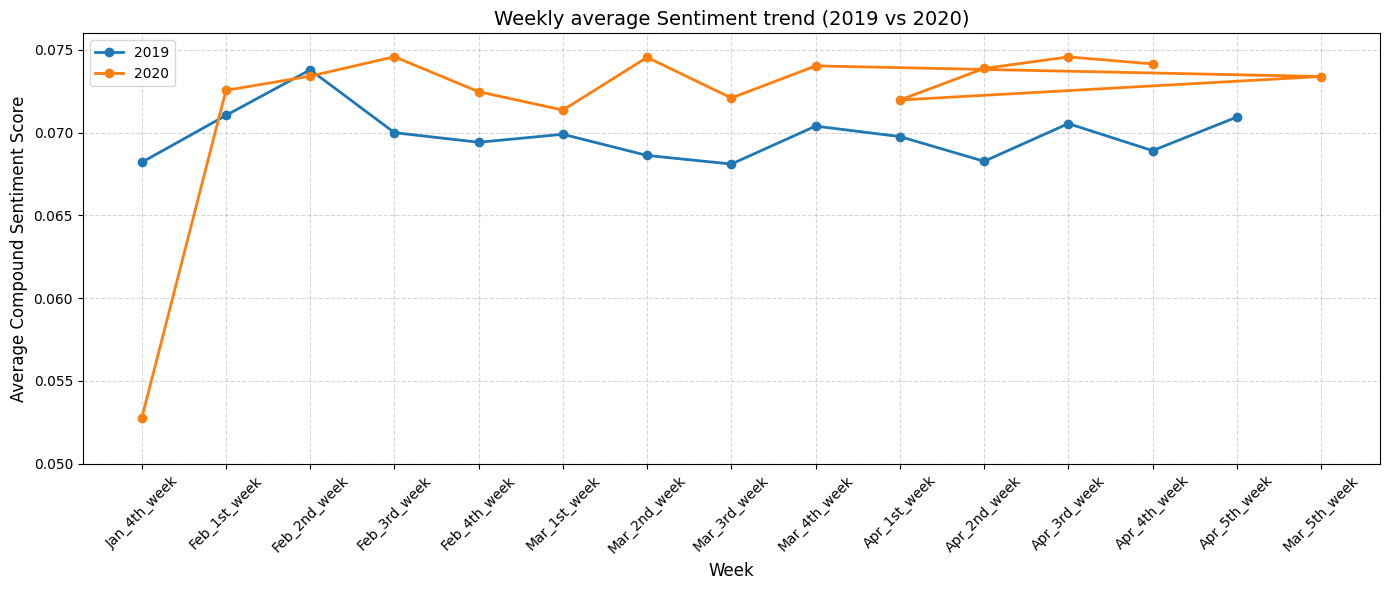

In [52]:
# plotting the weekly sentiment scores for both years
plt.figure(figsize=(14, 6))

# plotting each years trend
for year in ['2019', '2020']:
    data = sentiment_df[sentiment_df['label'] == year]
    plt.plot(data['week_label'], data['avg_sentiment'], marker='o', label=year, linewidth=2)

plt.title('Weekly average Sentiment trend (2019 vs 2020)', fontsize=14)
plt.xlabel('Week', fontsize=12)
plt.ylabel('Average Compound Sentiment Score', fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0.05, 0.076)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

The weekly average sentiment trend from February to April shows some distinct but meaningful differences between 2019 and 2020. In 2019, sentiment scores were fairly stable, mostly ranging from 0.068 to 0.073, reflecting a consistently mildly positive tone in developer communication. The highest score in 2019 was 0.0738 in the 2nd week of February, while dips like 0.0681 in mid March suggest brief slowdowns or neutral moods.  
In contrast, 2020 starts with a notably low sentiment of 0.0527 in late January, possibly reflecting initial uncertainty around the COVID-19 pandemic. But by February, scores quickly improve, jumping to 0.0725 in early February and peaking at 0.0746 in both mid February and again in April, consistently staying above 0.072 through most of the observed period. This sharp early rise followed by stability implies developers adapted positively, possibly due to community resilience or the shift to remote collaboration.   
Overall, 2020 shows a slightly more optimistic and consistent sentiment trend than 2019 after the initial dip.